# Transfer learning with TensorFlow Part 2: Fine-tuning

In [81]:
# Check if GPU is being used
!nvidia-smi

Wed Jun  2 00:43:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   4828MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [82]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-02 00:43:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-02 00:43:45 (98.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [83]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use pretrained models within `tf.keras.applications`

In [84]:
# Get 10% of the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2021-06-02 00:43:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 142.250.73.208, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   142MB/s    in 1.1s    

2021-06-02 00:43:47 (142 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [85]:
# Check out how many images and subdirectories are in our dataset?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [86]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [87]:
import tensorflow as tf

In [88]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# image_dataset_from_directory returns a BatchDataset
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical")

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           batch_size=BATCH_SIZE,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [89]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [90]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [91]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[182.20345   184.20345   199.20345  ]
   [206.9104    208.9104    223.9104   ]
   [168.76021   172.40306   186.76021  ]
   ...
   [199.90111   206.90111   216.90111  ]
   [198.39886   205.39886   215.39886  ]
   [187.09262   194.09262   204.09262  ]]

  [[182.78444   185.03891   200.03891  ]
   [206.64157   208.89604   223.89604  ]
   [167.27806   170.92091   185.38712  ]
   ...
   [205.        212.        222.       ]
   [206.58542   213.58542   223.58542  ]
   [198.35254   205.35254   215.35254  ]]

  [[182.6926    185.6926    200.6926   ]
   [206.7618    209.7618    224.7618   ]
   [164.6065    169.24904   183.70154  ]
   ...
   [204.48502   211.48502   221.48502  ]
   [208.14095   215.14095   225.14095  ]
   [204.29836   211.29836   221.29836  ]]

  ...

  [[207.2229    211.2229    212.2229   ]
   [205.        209.        210.       ]
   [198.45247   202.45247   203.45247  ]
   ...
   [196.12338   200.12338   199.55191  ]
   [196.        200.        199.       ]
   [1

# Keras Sequential API vs. Functional API
Main takeaway to keep things simple for now - the Functional API is more flexible and allows for more complex model architectures

### Model 0: Building a baseline model using transfer learning feature extraction with the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [92]:
# 1. Create base model with tf.keras.applications
baseline_model = tf.keras.applications.EfficientNetB0(include_top=False) # remove top layer, we want to customize that for feature extraction

# 2. Freeze  the base model (so the underlying pre-trained patterns aren't updated during training)
baseline_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. (Optional) - If using a model like ResNet50V2, you will need to normalize inputs (you don't have to for EfficientNet(s) - rescaling is built-in)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the model
x = baseline_model(inputs)
print(f"Shape after passing inputs through base model_0: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all of the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after passing inputs through GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9 . Compile model
model_0.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# 10. Fit and save history
baseline_model_history = model_0.fit(train_data_10_percent,
                                     epochs=5,
                                     steps_per_epoch=len(train_data_10_percent),
                                     validation_data=test_data_10_percent,
                                     validation_steps=int(0.25 * len(test_data_10_percent)), # only validate on 25%
                                     callbacks=[create_tensorboard_callback("logs", "baseline_model_0")])

Shape after passing inputs through base model_0: (None, 7, 7, 1280)
Shape after passing inputs through GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: logs/baseline_model_0/20210602-004355
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 12s 303ms/step - loss: 1.9081 - accuracy: 0.3987 - val_loss: 1.3215 - val_accuracy: 0.7451
Epoch 2/5
24/24 [==============================] - 5s 198ms/step - loss: 1.1485 - accuracy: 0.7453 - val_loss: 0.8805 - val_accuracy: 0.8174
Epoch 3/5
24/24 [==============================] - 5s 205ms/step - loss: 0.8470 - accuracy: 0.8093 - val_loss: 0.6982 - val_accuracy: 0.8635
Epoch 4/5
24/24 [==============================] - 5s 206ms/step - loss: 0.6836 - accuracy: 0.8480 - val_loss: 0.6221 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 5s 197ms/step - loss: 0.5854 - accuracy: 0.8493 - val_loss: 0.5823 - val_accuracy: 0.8470


In [93]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 9s 105ms/step - loss: 0.6078 - accuracy: 0.8436


[0.6077883839607239, 0.8435999751091003]

In [94]:
# Check the layers in our base model
for layer_number, layer in enumerate(baseline_model.layers):
  print(layer_number, layer.name)

0 input_4
1 rescaling_3
2 normalization_3
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [95]:
baseline_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, None, None, 3 7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_3[0][0]            
_____________________________________________________________________________________

In [96]:
model_0.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


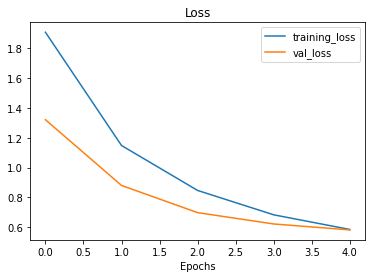

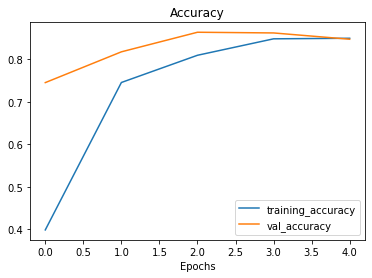

In [97]:
plot_loss_curves(baseline_model_history)

# SPLENDID

## Getting a feature vector

Let's demonstrate the Global Average Pooling 2D layer

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280)

In [98]:
#Define input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pool tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pool tensor: (1, 3)


In [99]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Note**: One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained models output a feature vector ( along tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of `tf.keras.layers.GlobalAveragePooling2D()` layer) which can be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it perform with 1% o the training data? Let's find out

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training dat with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` use fine-tuning transfer learning on 100% of the training data with data augmentation


**Note**: Throughout all experiments the same test dataset wil be used to evaluate our model. This ensures consistency across evaluation metrics.

In [100]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# Unzip
unzip_data("10_food_classes_1_percent.zip")

--2021-06-02 00:44:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 142.250.73.208, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   208MB/s    in 0.6s    

2021-06-02 00:44:38 (208 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [101]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [102]:
# How many images we got?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

In [103]:
# Setup data loaders
IMG_SIZE = (224, 224)
print("Loading training data...")
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

print("Loading test data...")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Loading training data...
Found 70 files belonging to 10 classes.
Loading test data...
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our mdoels, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

The benefits of using data augmentation (to name a couple):
* It runs on the GPU, not the CPU (like  ImageDataGenerator)
* Data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [104]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name="data_augmentation")

### Visualize our data augmentation layer and see what happens to the data

In [105]:
# View a random image and compare it to its augmented state
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def plot_images_pre_post_augmentation():

  target_class = random.choice(train_data_10_percent.class_names)
  target_dir = "10_food_classes_1_percent/train/" + target_class
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + "/" + random_image
  # Read and plot random image
  img = mpimg.imread(random_image_path)
  plt.imshow(img)
  plt.title(f"Original random image from class: {target_class}")
  plt.axis(False);

  # Now let's plot our augmented random image
  augmented_image = data_augmentation(tf.expand_dims(img, axis=0))
  plt.figure()
  plt.imshow(tf.squeeze(augmented_image)/255.)
  plt.title(f"Image after augmentation")
  plt.axis(False)

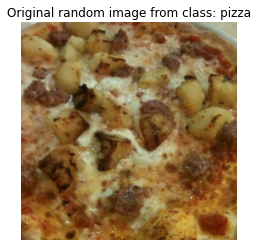

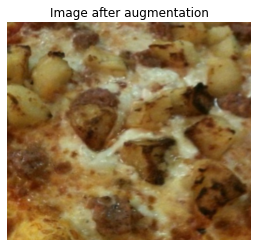

In [106]:
plot_images_pre_post_augmentation()

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [107]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Creating input layers

inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs after augmentation and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a Dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback("logs", "model_1_1_percent_data_aug")])

Saving TensorBoard log files to: logs/model_1_1_percent_data_aug/20210602-004443
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 10s 3s/step - loss: 2.4681 - accuracy: 0.0429 - val_loss: 2.2505 - val_accuracy: 0.1414
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1913 - accuracy: 0.2000 - val_loss: 2.1344 - val_accuracy: 0.2237
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 2.0262 - accuracy: 0.3143 - val_loss: 2.0421 - val_accuracy: 0.2829
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8539 - accuracy: 0.4857 - val_loss: 1.9400 - val_accuracy: 0.3553
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6742 - accuracy: 0.6000 - val_loss: 1.8510 - val_accuracy: 0.4161


In [108]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [109]:
# Evaluate on the full test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 9s 107ms/step - loss: 1.8545 - accuracy: 0.4120


[1.8545037508010864, 0.41200000047683716]

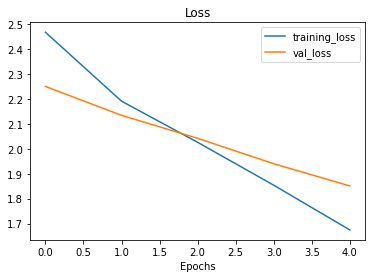

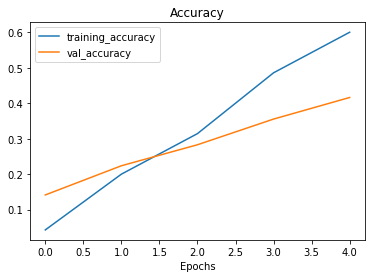

In [110]:
# How does the model perform?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [111]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [112]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [113]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)
  # preprocessing.Rescaling(1./255) - could use this if using ResNet50V2 or others that don't rescale images
], name="data_augmentation")

In [114]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # pass augmneted images to base model but keep it in inference mode - this also ensures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
model_2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermittenly saves our model (the full model or just the weights) during training.

In [115]:
# Set checkpoint path
checkpoint_path = "ten_10_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", verbose=1)

In [116]:
history_model_2 = model_2.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=len(test_data),
            callbacks=[create_tensorboard_callback("logs", "model_2_10_percent_data_aug"),
                       checkpoint_callback])

Saving TensorBoard log files to: logs/model_2_10_percent_data_aug/20210602-004533
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 19s 616ms/step - loss: 2.0140 - accuracy: 0.3253 - val_loss: 1.5109 - val_accuracy: 0.6444

Epoch 00001: saving model to ten_10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 12s 493ms/step - loss: 1.3492 - accuracy: 0.6693 - val_loss: 1.0728 - val_accuracy: 0.7656

Epoch 00002: saving model to ten_10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 13s 539ms/step - loss: 1.0595 - accuracy: 0.7267 - val_loss: 0.8709 - val_accuracy: 0.7900

Epoch 00003: saving model to ten_10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 13s 520ms/step - loss: 0.9110 - accuracy: 0.7720 - val_loss: 0.7581 - val_accuracy: 0.8136

Epoch 00004: saving model to ten_10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 13s 536ms/step - loss: 0.7952 - accuracy: 0

In [117]:
model_0.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.6078 - accuracy: 0.8436


[0.6077883243560791, 0.8435999751091003]

In [118]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 9s 105ms/step - loss: 0.6886 - accuracy: 0.8240


[0.688607394695282, 0.8240000009536743]

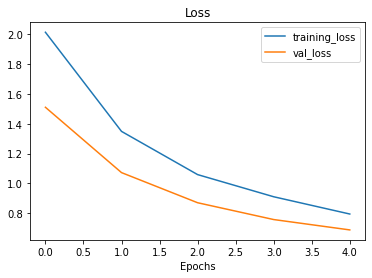

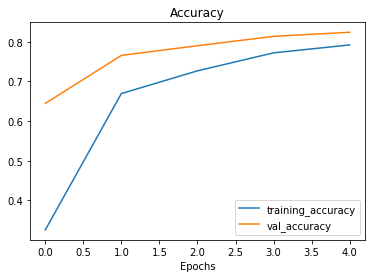

In [119]:
plot_loss_curves(history_model_2)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint.

In [120]:
model_2.load_weights(checkpoint_path)

In [121]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.6886 - accuracy: 0.8240


In [122]:
# If the results from our previously evaluated model-2 match the loaded weights, everything has worked
results_10_percent_data_aug == loaded_weights_model_results

False

In [123]:
results_10_percent_data_aug

[0.688607394695282, 0.8240000009536743]

In [124]:
loaded_weights_model_results

[0.6886076331138611, 0.8240000009536743]

In [125]:
# Check to see if loaded model results are very close to our previou non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [126]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-2.38418579e-07  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

**Note**: Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [127]:
# Layers in loaded model_2
model_2.layers

In [128]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f0055155ed0> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f0060ff2890> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f005c8667d0> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f0059cb7710> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f0058832c90> True


In [129]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [130]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [131]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Checking to make sure the last 10 layers are unfrozen
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)


0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Recompile (we have to recompile our models everytime we make a change)
When fine-tuning, you typically want to lower the learning rate by 10x
**Note:** When using fine-tuning, it's best practice to lower your learning rate by some amount. How much?
This is a hyperparameter you can tune but a good rule of thumb is at least 10x

In [132]:
model_2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [133]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [134]:
print(len(model_2.trainable_variables))

12


In [135]:
# Fine tune for another 5 epochs
fine_tune_epochs = 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_model_2.epoch[-1], # start training from previous epoch
                                               callbacks=[create_tensorboard_callback("logs", "10_percent_fine_tune_last_10_layers")])

Saving TensorBoard log files to: logs/10_percent_fine_tune_last_10_layers/20210602-004740
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 14s 364ms/step - loss: 0.7062 - accuracy: 0.7960 - val_loss: 0.5580 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 7s 261ms/step - loss: 0.5842 - accuracy: 0.8293 - val_loss: 0.4737 - val_accuracy: 0.8503
Epoch 7/10
24/24 [==============================] - 6s 247ms/step - loss: 0.4901 - accuracy: 0.8480 - val_loss: 0.4801 - val_accuracy: 0.8569
Epoch 8/10
24/24 [==============================] - 7s 284ms/step - loss: 0.4428 - accuracy: 0.8707 - val_loss: 0.4694 - val_accuracy: 0.8569
Epoch 9/10
24/24 [==============================] - 7s 289ms/step - loss: 0.4348 - accuracy: 0.8587 - val_loss: 0.4801 - val_accuracy: 0.8503
Epoch 10/10
24/24 [==============================] - 7s 277ms/step - loss: 0.3982 - accuracy: 0.8773 - val_loss: 0.4511 - val_accuracy: 0.8536


In [136]:
# Evaluate the fine-tuned model (model_3 which is just model_2 but fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.4948 - accuracy: 0.8336


In [137]:
results_10_percent_data_aug

[0.688607394695282, 0.8240000009536743]

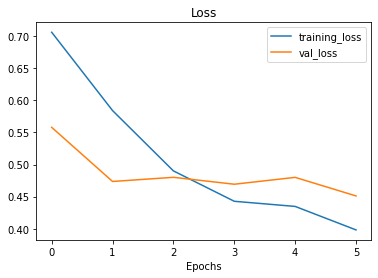

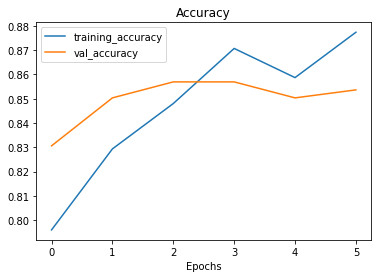

In [138]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning

In [139]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

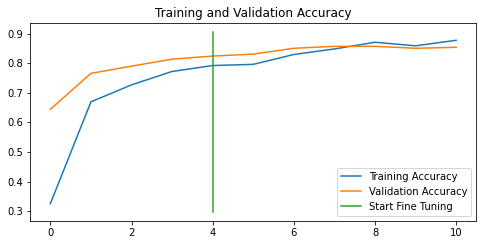

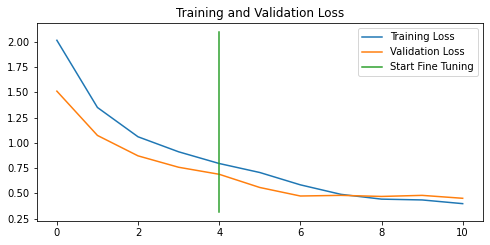

In [140]:
compare_histories(history_model_2, history_fine_10_percent_data_aug, initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data

In [141]:
# Download and unzip data - all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-06-02 00:48:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   248MB/s    in 2.0s    

2021-06-02 00:48:55 (248 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [142]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir_all_data = "10_food_classes_all_data/test"

In [143]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 

In [144]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_all_data,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiements (all experiments have used the same test dataset)

Let's verify this...

In [145]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 108ms/step - loss: 0.4948 - accuracy: 0.8336


[0.49475961923599243, 0.8335999846458435]

In [146]:
results_fine_tune_10_percent

[0.4947596788406372, 0.8335999846458435]

**BAM**

To train a fine-tuning model (model 4) we need to revert model_2 back to its feature extraction weights.

### Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from

In [147]:
model_2.load_weights(checkpoint_path)

In [148]:
# Let's evaluate model_2 now - if the weights went back, the results here should be worse than what we saw a
# couple lines above
model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.6886 - accuracy: 0.8240


[0.6886076331138611, 0.8240000009536743]

In [149]:
results_10_percent_data_aug

[0.688607394695282, 0.8240000009536743]

Alright, the previous steps might seem quite confusing but all we've done is:

* Trained a feautre extraction transfer learning model for 5 epochs on 10% of the data with augmentation (`model_2`) and we saved the model's weights using the `ModelCheckpoint` callback.
* Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (`model_3`)
* Saved the results and training logs each time
* Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (`model_4`) 

In [150]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [151]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [152]:
# Compile 
model_2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [153]:
# Continue to train and fine-tune the model to our data (100% of the training data)
fine_tune_epochs = 10
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_model_2.epoch[-1],
                                           callbacks=[create_tensorboard_callback("logs", "full_10_classes_fine_tune_last_10_layers")])

Saving TensorBoard log files to: logs/full_10_classes_fine_tune_last_10_layers/20210602-004927
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 42s 159ms/step - loss: 0.7302 - accuracy: 0.7641 - val_loss: 0.4167 - val_accuracy: 0.8536
Epoch 6/10
235/235 [==============================] - 42s 179ms/step - loss: 0.5988 - accuracy: 0.8072 - val_loss: 0.4059 - val_accuracy: 0.8717
Epoch 7/10
235/235 [==============================] - 41s 171ms/step - loss: 0.5309 - accuracy: 0.8288 - val_loss: 0.3827 - val_accuracy: 0.8750
Epoch 8/10
235/235 [==============================] - 39s 165ms/step - loss: 0.4840 - accuracy: 0.8417 - val_loss: 0.3882 - val_accuracy: 0.8865
Epoch 9/10
235/235 [==============================] - 39s 163ms/step - loss: 0.4489 - accuracy: 0.8532 - val_loss: 0.3614 - val_accuracy: 0.8849
Epoch 10/10
235/235 [==============================] - 38s 160ms/step - loss: 0.4170 - accuracy: 0.8625 - val_loss: 0.3443 - val_accuracy: 0.8882


In [154]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 9s 104ms/step - loss: 0.3091 - accuracy: 0.8972


[0.30909964442253113, 0.8971999883651733]

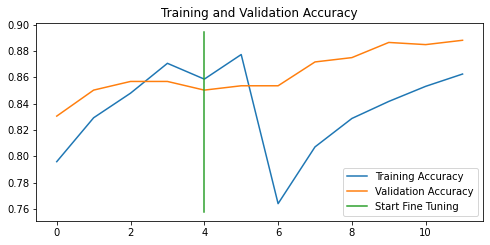

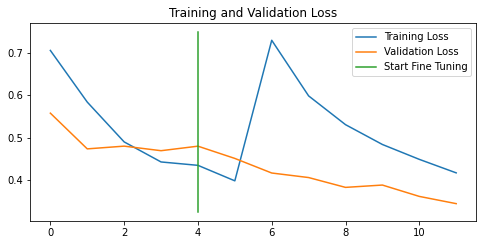

In [155]:
compare_histories(original_history=history_fine_10_percent_data_aug, new_history=history_fine_10_classes_full, initial_epochs=5)

## Viewing our experiment data on TensorBoard

In [156]:
# View tensorboard logs of transfer learning modelling experiments
# Upload TensorBoard dev records
!tensorboard dev --logdir /content/logs --name "Transfer Learning Experiments with 10 Food101 Classes" --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" --one_shot

2021-06-02 00:54:25.860431: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
usage: tensorboard dev [-h] [--helpfull] [--origin ORIGIN]
                       [--api_endpoint API_ENDPOINT]
                       [--grpc_creds_type {local,ssl,ssl_dev}]
                       [--auth_force_console]
                       {upload,update-metadata,delete,list,export,auth} ...
tensorboard dev: error: invalid choice: '/content/logs' (choose from 'upload', 'update-metadata', 'delete', 'list', 'export', 'auth')


# End of Section Exercises

* 1. Write a function to visualize an image from any dataset (train or test) and any class, visualize it and make a prediction on it using a trained model.
* 2. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. use the `ModelCheckpoint` callback to save the weights of the file.
* 3. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. What happens?
* 4. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. What happens?

### 1. Write a function to visualize an image from any dataset (train or test) and any class, visualize it and make a prediction on it using a trained model.

In [160]:
unique_foods = train_data_10_classes_full.class_names
unique_foods

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [168]:
def get_pred_label(prediction_probabilities):
  return unique_foods[np.argmax(prediction_probabilities)]

In [192]:
# Function that visualizes an image and makes a prediction on it
# Imports for completeness
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def plot_and_predict(model, class_name):
  """
  Returns a visualized image of any of the available classes along with a prediction
  """
  target_class = class_name
  target_dir = "10_food_classes_10_percent/train/" + target_class
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + "/" + random_image

  # Image shit
  img = mpimg.imread(random_image_path)

  pred_prob = model.predict(img, verbose=0)
  pred_label = get_pred_label(pred_prob)

  plt.imshow(img)
  plt.title("{} {:2.0f}%".format(pred_label, np.max(pred_prob)*100))
  plt.axis(False)
  plt.xticks([])
  plt.yticks([])

In [195]:
plot_and_predict(model_2, "steak")

ValueError: ignored